In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm_notebook as tqdm
from cycler import cycler

In [2]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 26
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#CF353C', '#FFE3A6',
#                                                 '#727272'])

In [3]:
mpl.rcParams['axes.prop_cycle']

'#E24A33'
'#348ABD'
'#988ED5'
'#777777'
'#FBC15E'
'#8EBA42'
'#FFB5B8'


# Data Extraction

In [4]:
df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


# Exploratory Data Analysis

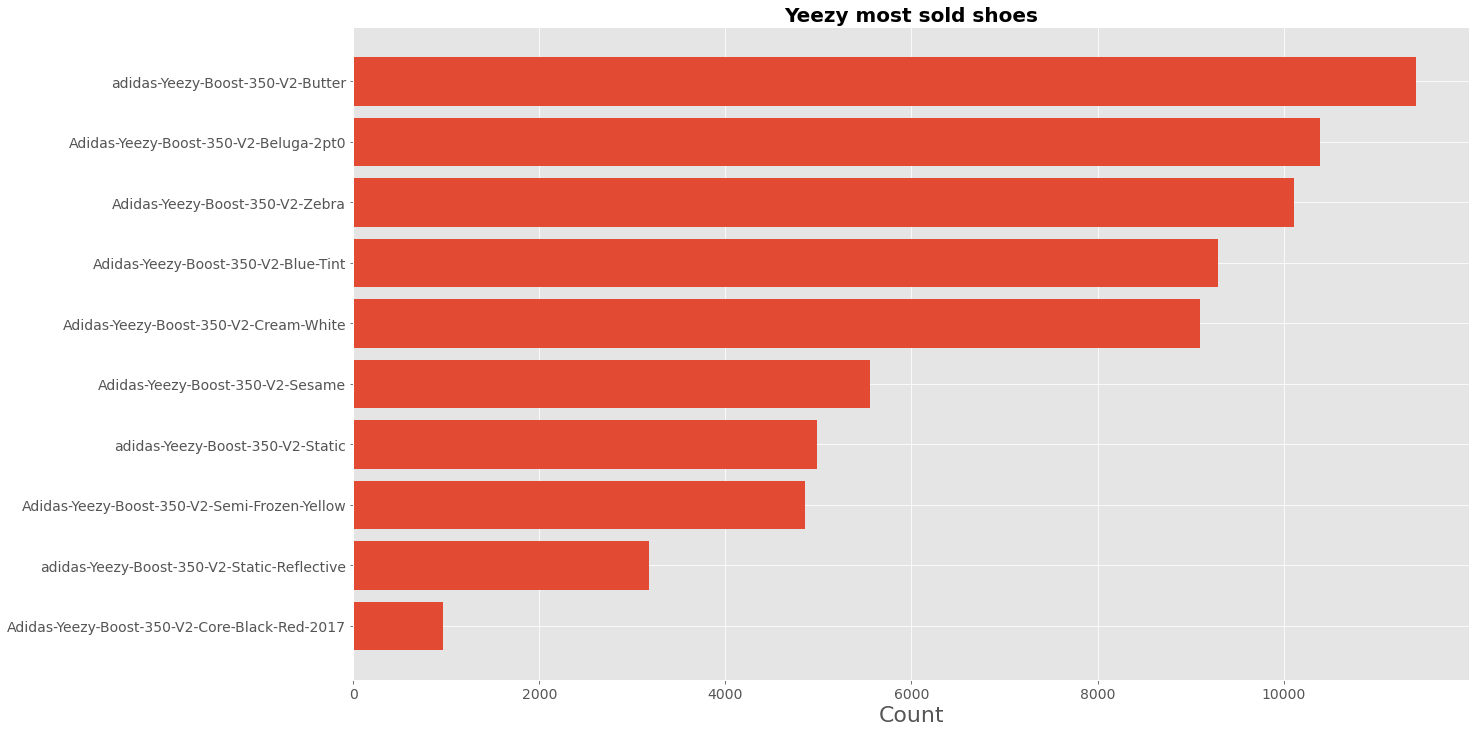

In [14]:
freq_shoes = (df.loc[df.Brand == ' Yeezy'].groupby(['Sneaker Name'])
              .size().nlargest(10).reset_index().sort_values(by=0))

# freq_shoes['Variant'] = (freq_shoes['Sneaker Name'].astype(str)
#                          + '_' + freq_shoes['Shoe Size'].astype(str))

freq_shoes.sort_values(by=0, inplace=True, ascending=True)

plt.figure(figsize=(20, 12))
plt.barh(freq_shoes['Sneaker Name'], width=freq_shoes[0])
plt.xlabel('Count')
# plt.xlim(900)
plt.title('Yeezy most sold shoes')
plt.show()
# del freq_shoes

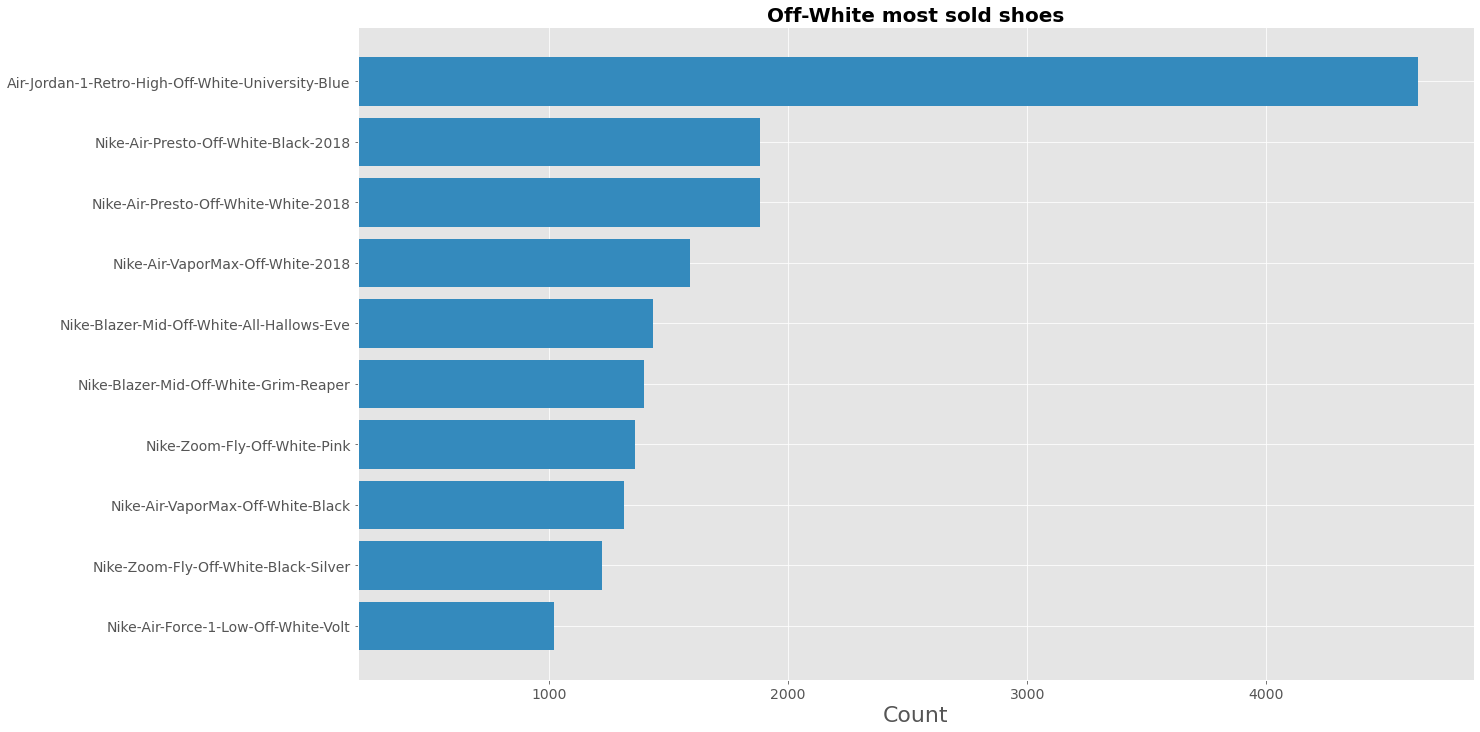

In [13]:
freq_shoes = (df.loc[df.Brand == 'Off-White'].groupby(['Sneaker Name'])
              .size().nlargest(10).reset_index().sort_values(by=0))

# freq_shoes['Variant'] = (freq_shoes['Sneaker Name'].astype(str)
#                          + '_' + freq_shoes['Shoe Size'].astype(str))
freq_shoes.sort_values(by=0, inplace=True)
plt.figure(figsize=(20, 12))
plt.barh(freq_shoes['Sneaker Name'], width=freq_shoes[0], color='#348ABD')
plt.xlabel('Count')
plt.xlim(200)
plt.title('Off-White most sold shoes')
plt.show()

In [16]:
def get_shoes(name, size=None):
    """Get data for shoes, all shoe size if size is None"""
    if size is None:
        return df.loc[df['Sneaker Name'] == name].copy()
    else:
        m1 = df['Sneaker Name'] == name
        m2 = df['Shoe Size'] == size
        return df.loc[m1 & m2].copy()

## Yeezy Beluga Size 10

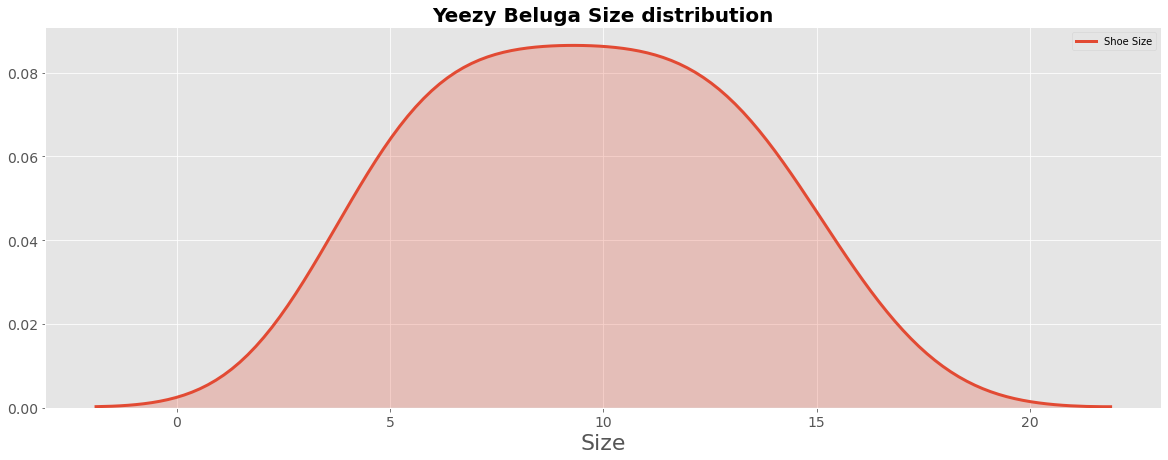

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0')
            .groupby('Shoe Size')['Shoe Size']
            .mean().sort_index(), shade=True)

ymean = get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0')['Shoe Size'].mean()
plt.title('Yeezy Beluga Size distribution')
plt.xlabel('Size');

In [29]:
yeezy_beluga_10 = get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0', 10)

Number of sold dates for size 10:  340


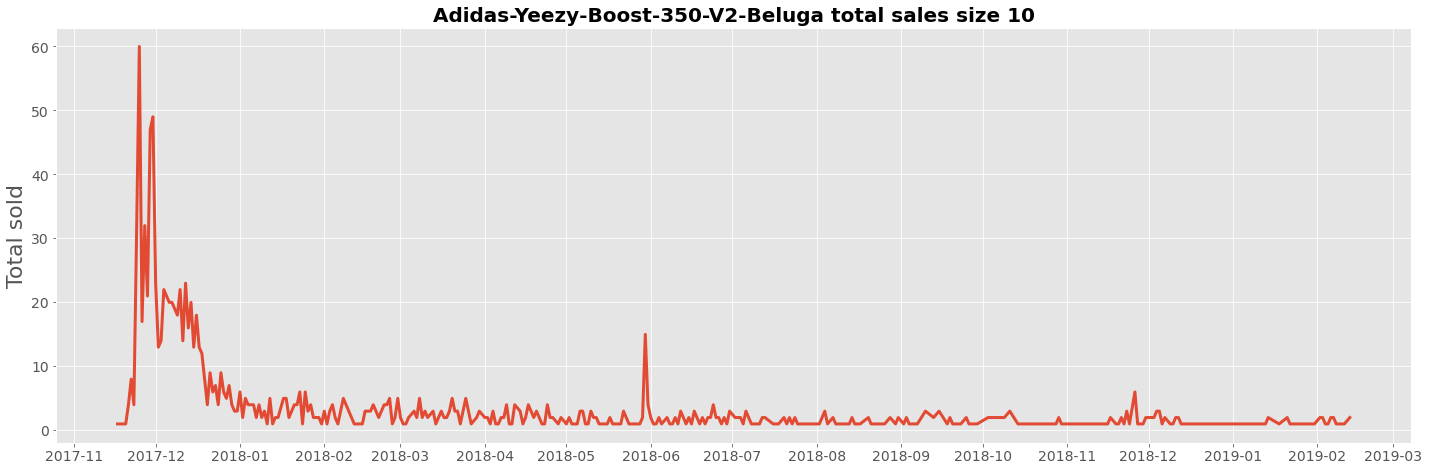

In [30]:
print('Number of sold dates for size 10: ',
      yeezy_beluga_10['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(yeezy_beluga_10['Order Date'].value_counts().sort_index())
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Total sold')

plt.title('Adidas-Yeezy-Boost-350-V2-Beluga total sales size 10')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Number of sold dates for size 10:  340


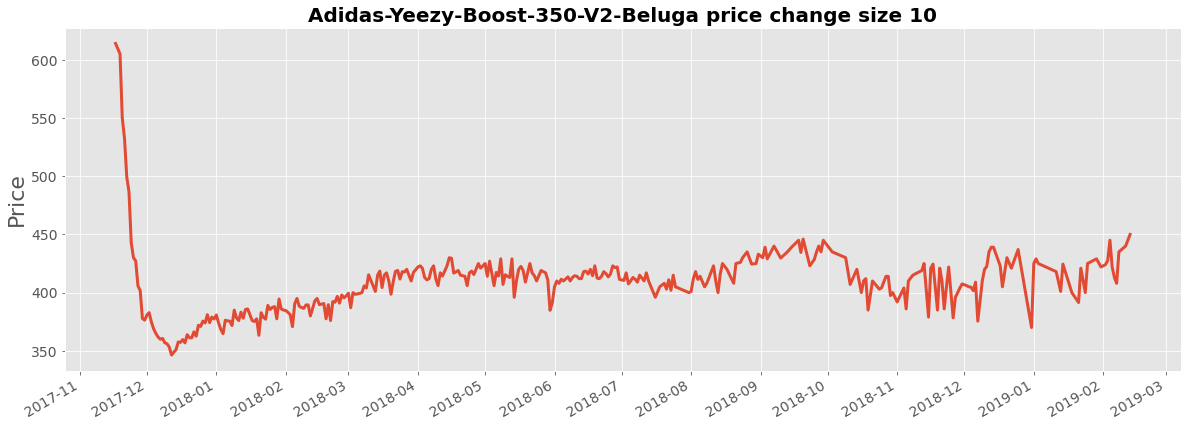

In [31]:
print('Number of sold dates for size 10: ',
      yeezy_beluga_10['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(yeezy_beluga_10.groupby('Order Date')['Sale Price']
        .mean().sort_index())
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.title('Adidas-Yeezy-Boost-350-V2-Beluga price change size 10')
fig.autofmt_xdate()

plt.show()

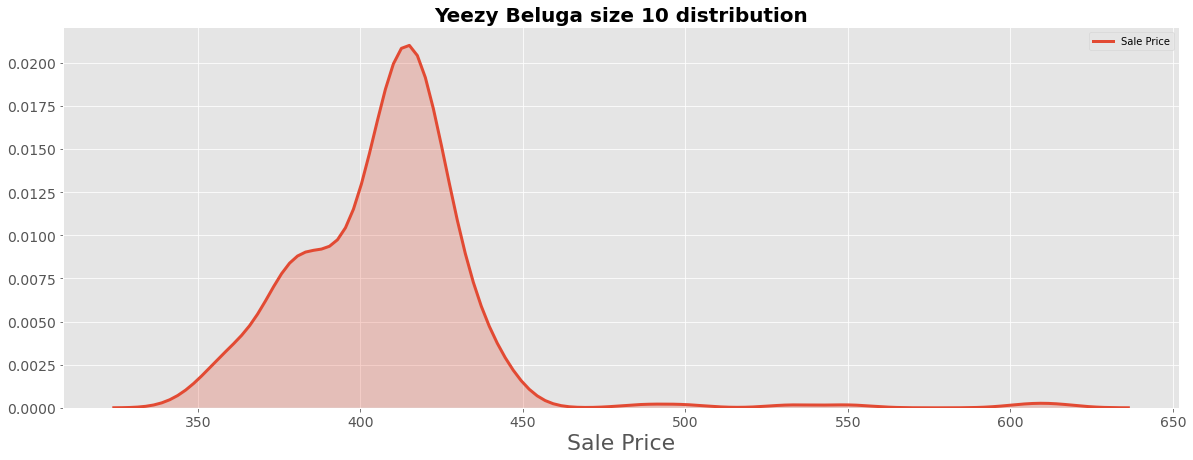

In [32]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(yeezy_beluga_10.groupby('Order Date')['Sale Price']
            .mean().sort_index(), shade=True)
plt.title('Yeezy Beluga size 10 distribution')
plt.xlabel('Sale Price');

## Jordan 1 Retro University Blue Size 9

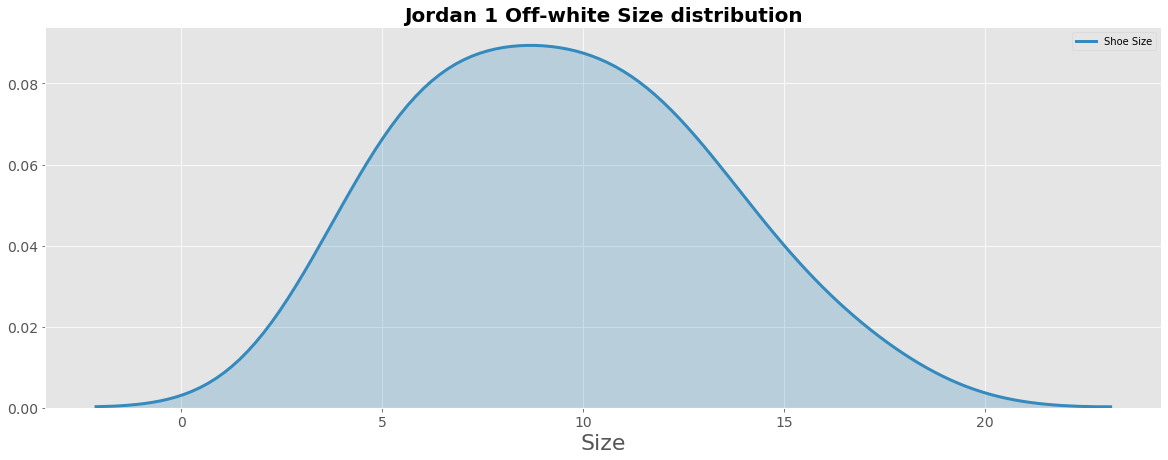

In [33]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(get_shoes('Air-Jordan-1-Retro-High-Off-White-University-Blue')
            .groupby('Shoe Size')['Shoe Size']
            .mean().sort_index(), shade=True, color='#348ABD')
plt.title('Jordan 1 Off-white Size distribution')
plt.xlabel('Size');

In [21]:
jordan1_uni_blue_9 = get_shoes(
    'Air-Jordan-1-Retro-High-Off-White-University-Blue', 9)

Number of sold dates for size 10:  108


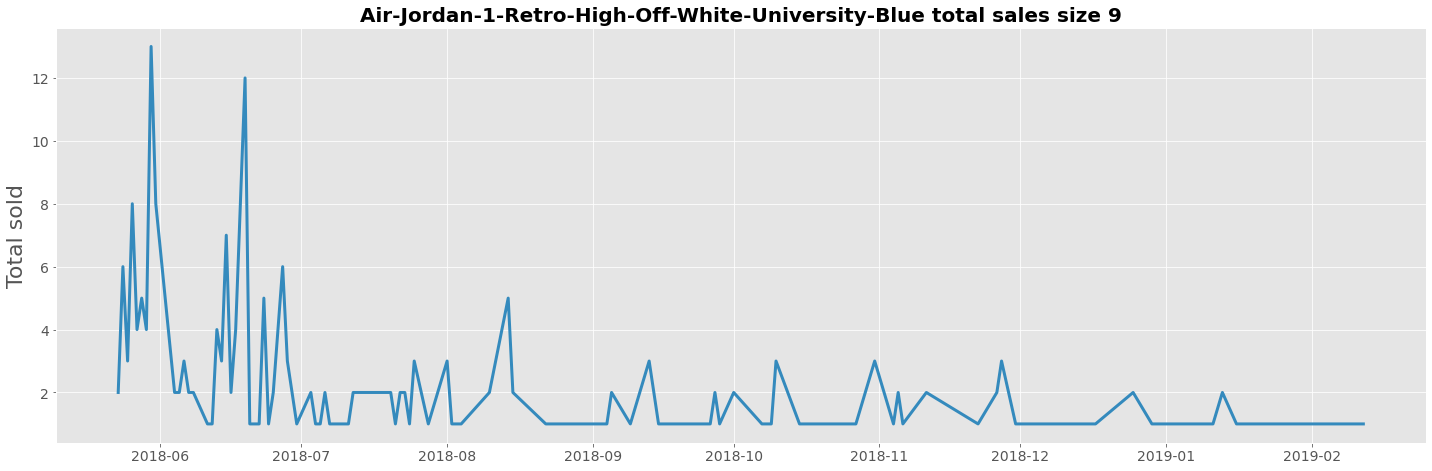

In [22]:
print('Number of sold dates for size 10: ',
      jordan1_uni_blue_9['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(jordan1_uni_blue_9['Order Date'].value_counts().sort_index(),
        color='#348ABD')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Total sold')

plt.title('Air-Jordan-1-Retro-High-Off-White-University-Blue total '
          'sales size 9')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Number of sold dates for size 10:  108


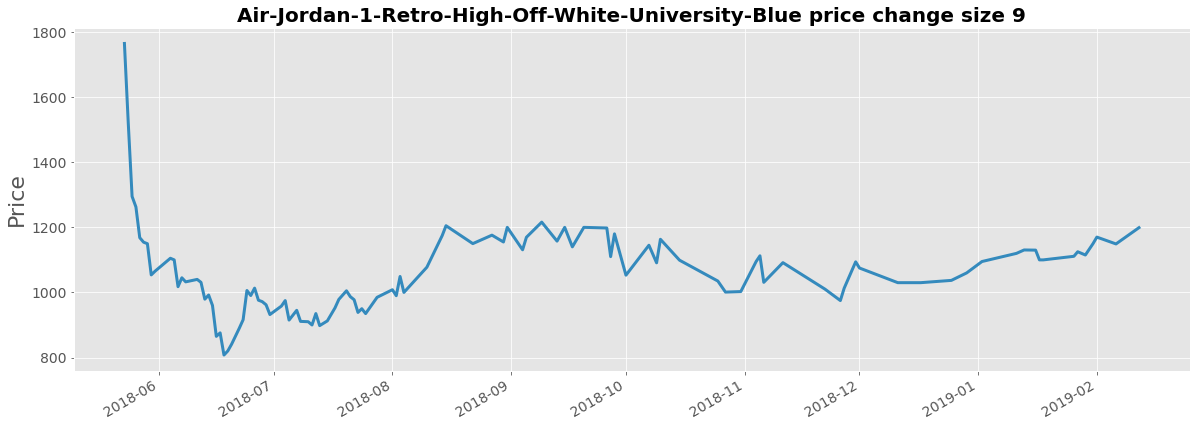

In [13]:
print('Number of sold dates for size 10: ',
      jordan1_uni_blue_9['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(jordan1_uni_blue_9.groupby('Order Date')['Sale Price']
        .mean().sort_index(), color='#348ABD')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.title('Air-Jordan-1-Retro-High-Off-White-University-Blue '
          'price change size 9')
fig.autofmt_xdate()

plt.show()

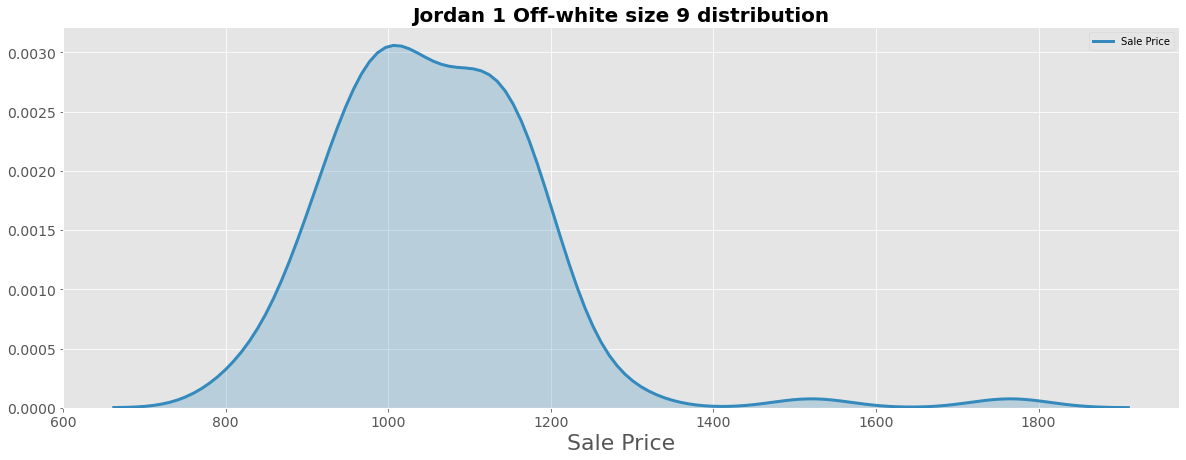

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(jordan1_uni_blue_9.groupby('Order Date')['Sale Price']
            .mean().sort_index(),
            color='#348ABD',
            shade=True)
plt.title('Jordan 1 Off-white size 9 distribution')
plt.xlabel('Sale Price');

# Data Processing

## Interpolation

In [15]:
def fill_dates(df, start, end):
    """Fill the dates of the data frame from start to end"""
    df_new = pd.DataFrame(columns=['Order Date'])
    df_new['Order Date'] = pd.date_range(start=start, end=end)
    df_new = pd.merge(df_new, df, on='Order Date', how='left')

    # Impute missing values
    brand = df['Brand'].values[0]
    sneaker_name = df['Sneaker Name'].values[0]
    retail_price = df['Retail Price'].values[0]
    shoe_size = df['Shoe Size'].values[0]

    df_new['Brand'] = df_new['Brand'].fillna(brand)
    df_new['Sneaker Name'] = (df_new['Sneaker Name'].fillna(sneaker_name))
    df_new['Retail Price'] = (df_new['Retail Price'].fillna(retail_price))
    df_new['Shoe Size'] = (df_new['Shoe Size'].fillna(shoe_size))
    df_new['Sale Price'] = (df_new['Sale Price'].interpolate(method='ffill'))
    return df_new

### Yeezy Beluga

In [16]:
start_date = yeezy_beluga_10.loc[yeezy_beluga_10['Order Date']
                                 > '2018-01-01', 'Order Date'].min()
end_date = yeezy_beluga_10.loc[yeezy_beluga_10['Order Date']
                               > '2018-01-01', 'Order Date'].max()
yeezy_beluga_10_new = fill_dates(yeezy_beluga_10, start_date, end_date)

Highest price is 450.00 USD
Lowest price is 358.00 USD


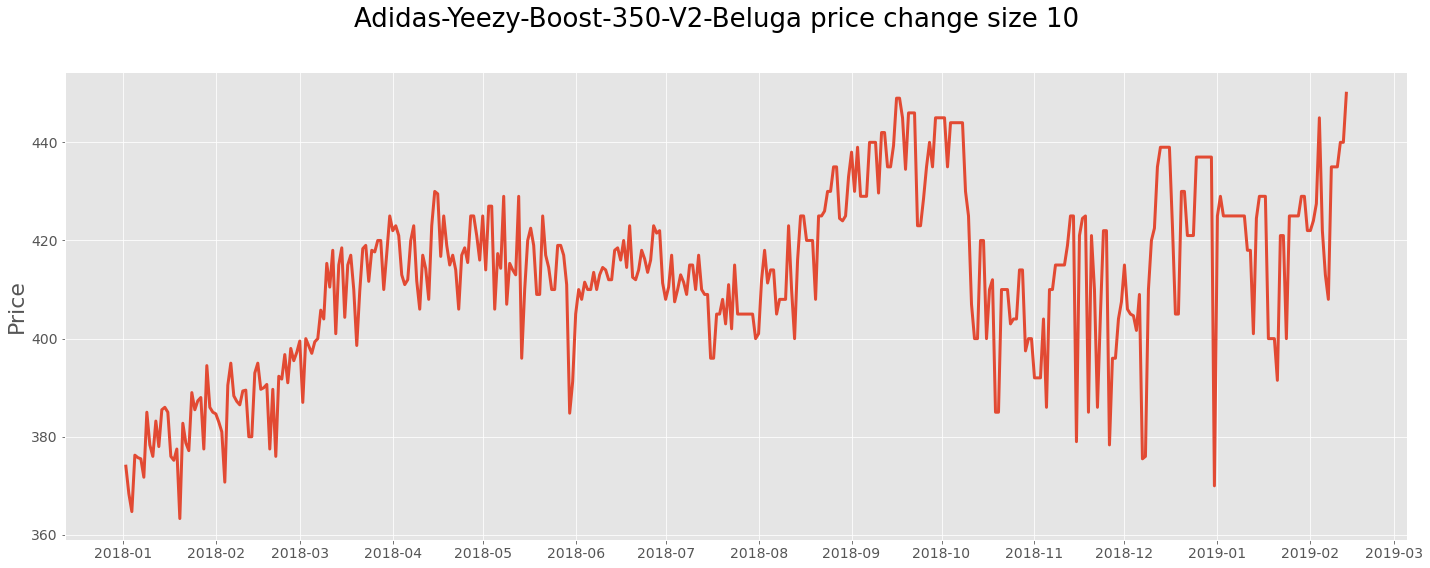

In [17]:
print('Highest price is %.2f USD' % yeezy_beluga_10_new['Sale Price'].max())
print('Lowest price is %.2f USD' % yeezy_beluga_10_new['Sale Price'].min())


fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax.plot(yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
        .mean().sort_index())

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.suptitle('Adidas-Yeezy-Boost-350-V2-Beluga price change size 10')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

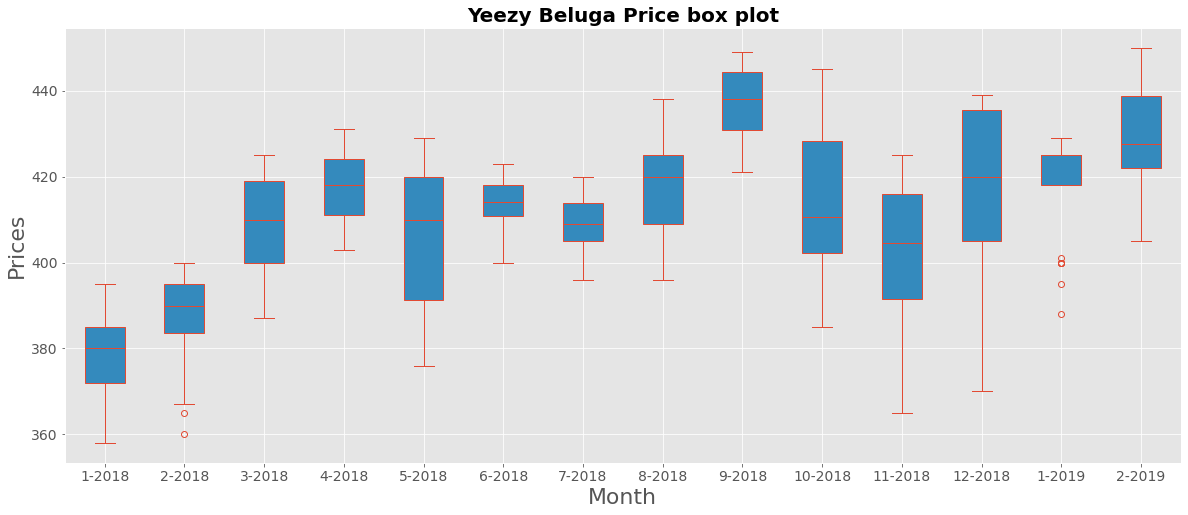

In [18]:
groups = yeezy_beluga_10_new.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='#E24A33'),
            whiskerprops=dict(color='#E24A33'),
            flierprops=dict(color='#E24A33', markeredgecolor='#E24A33'),
            medianprops=dict(color='#E24A33'),
            capprops=dict(color='#E24A33'))

plt.title('Yeezy Beluga Price box plot')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

### Jordan 1 Off-white

In [19]:
start_date = jordan1_uni_blue_9.loc[jordan1_uni_blue_9['Order Date']
                                    > '2018-06-01', 'Order Date'].min()
end_date = jordan1_uni_blue_9.loc[jordan1_uni_blue_9['Order Date']
                                  > '2018-01-01', 'Order Date'].max()
jordan1_uni_blue_9_new = fill_dates(jordan1_uni_blue_9, start_date, end_date)

Highest price is 1216.00 USD
Lowest price is 790.00 USD


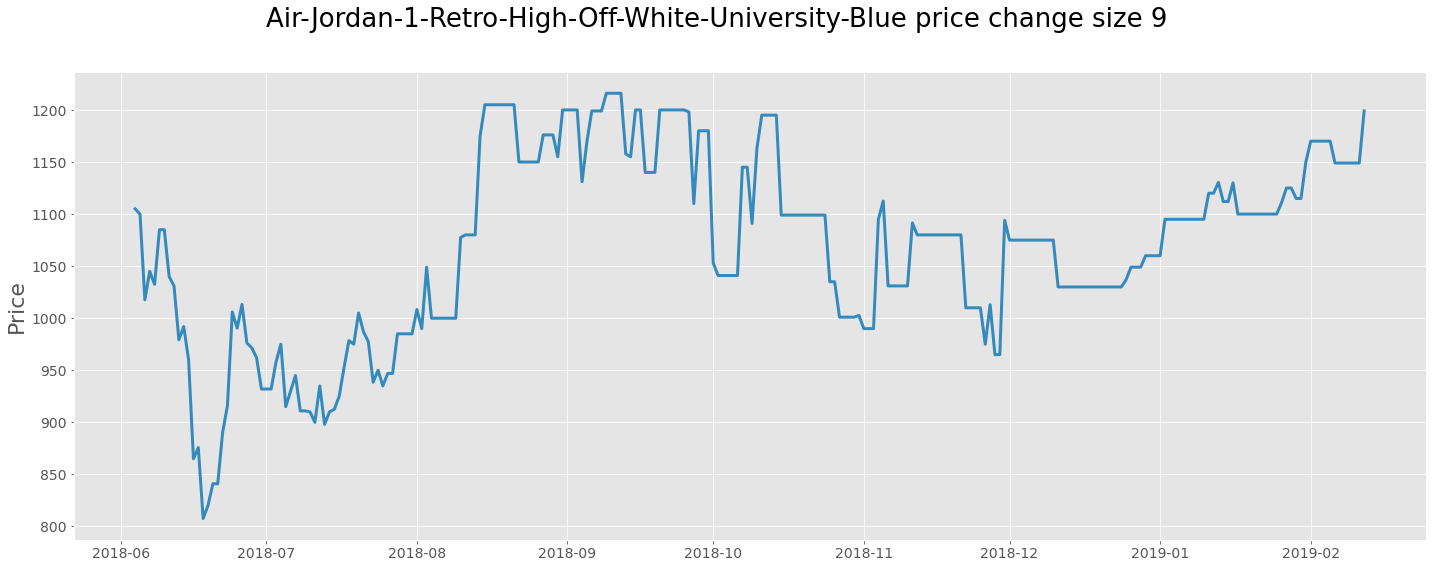

In [20]:
print('Highest price is %.2f USD' %
      jordan1_uni_blue_9_new['Sale Price'].max())
print('Lowest price is %.2f USD' % jordan1_uni_blue_9_new['Sale Price'].min())


fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax.plot(jordan1_uni_blue_9_new.groupby('Order Date')['Sale Price']
        .mean().sort_index(), color='#348ABD')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.suptitle(
    'Air-Jordan-1-Retro-High-Off-White-University-Blue price change size 9')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

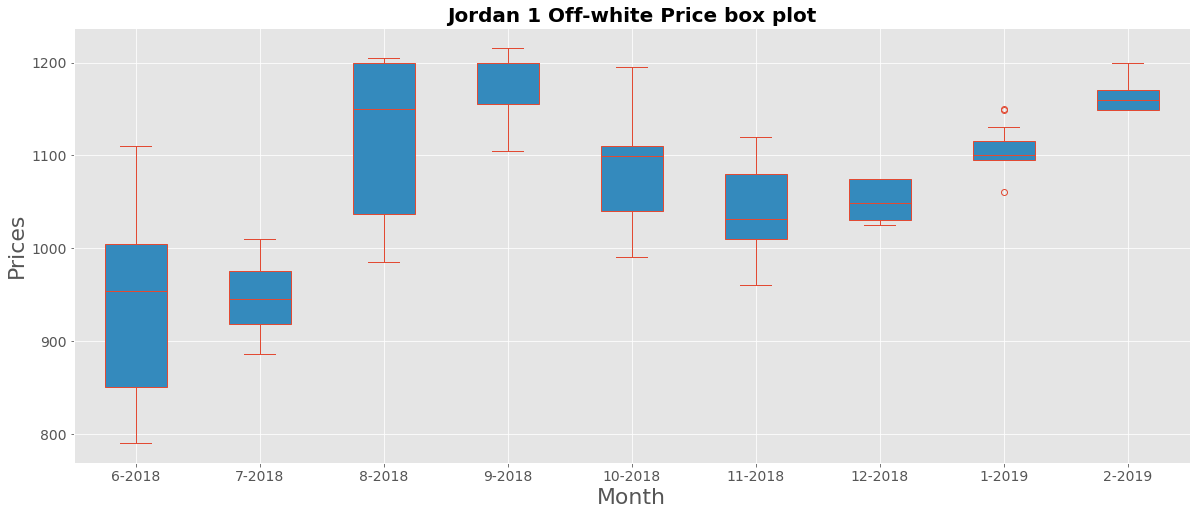

In [21]:
groups = jordan1_uni_blue_9_new.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                   label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='#E24A33'),
            whiskerprops=dict(color='#E24A33'),
            flierprops=dict(color='#E24A33', markeredgecolor='#E24A33'),
            medianprops=dict(color='#E24A33'),
            capprops=dict(color='#E24A33'))

plt.title('Jordan 1 Off-white Price box plot')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

# Grid Search ARIMA Yeezy Beluga

In [22]:
def is_stationary(timeseries, window=7):
    """Plot timeseries with rolling mean and std, cacl ADF stat"""
    # rolling statistics
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()

    # rolling statistics plot
    fig = plt.figure(figsize=(20, 5))
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label='Rolling Std')
    fig.autofmt_xdate()

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


def difference(dataset, interval=1):
    """Creates a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def inverse_difference(history, yhat, interval=1):
    """Inverse Difference of yhat"""
    return yhat + history[-interval]


def evaluate_arima_model(X, arima_order, window, bias=None):
    """Evaluate ARIMA model"""
    X = X.astype('float32')
    test_size = int(len(X) * 0.25)
    train, test = X.iloc[0:-test_size], X.iloc[-test_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        diff = difference(history, window)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat += bias
        predictions.append(yhat)
        history.append(test[i])
    # Calculate out of sample error
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test, predictions)
    return mae, rmse, r2, test, predictions


def evaluate_models(dataset, p_values, d_values, q_values, window):
    dataset = dataset.astype('float32')
    best_mae, best_rmse, best_cfg = float('inf'), float('inf'), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mae, mse, r2, test, pred = evaluate_arima_model(dataset,
                                                                    order,
                                                                    window)
                    print('ARIMA %s MAE = %.3f RMSE = %.3f R2 = %.3f' %
                          (order, mae, mse, r2))
                    if mae < best_mae:
                        best_mae, best_rmse, best_cfg = mae, mse, order
                except:
                    continue
    print('Best ARIMA %s MAE=%.3f RMSE= %.3f' % (best_cfg,
                                                 best_mae,
                                                 best_rmse))
    return best_cfg


def validate_model(test, train, model_fit, bias, arima_order, window):
    """Validate test using the fitted model of ARIMA"""
    # Make first prediction
    predictions = list()
    history = list(train.values.astype('float32'))
    y = test.values.astype('float32')
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, window)
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecast
    for i in range(1, len(y)):
        # Difference data
        diff = difference(history, window)
        # Predict
        model = ARIMA(diff, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
#         yhat = model_fit.predict(0)[0]
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat = yhat + bias
        predictions.append(yhat)
        # Observation
        history.append(y[i])
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[i]))

    # Report performance
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    return mae, rmse, r2, y, predictions

In [23]:
sale_price = (yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
train_price = sale_price.loc[sale_price.index <= '2018-11-15'].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-11-15'].copy()

## Raw Data

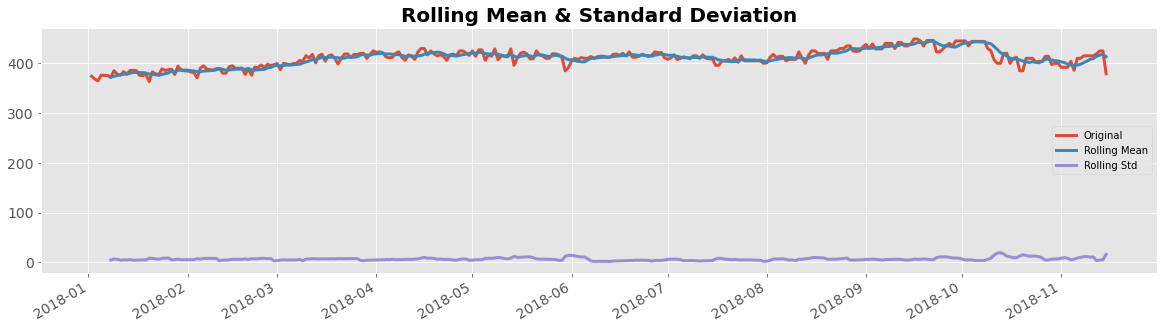

ADF Statistic: -2.6115298788689048
p-value: 0.09063761391742214
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


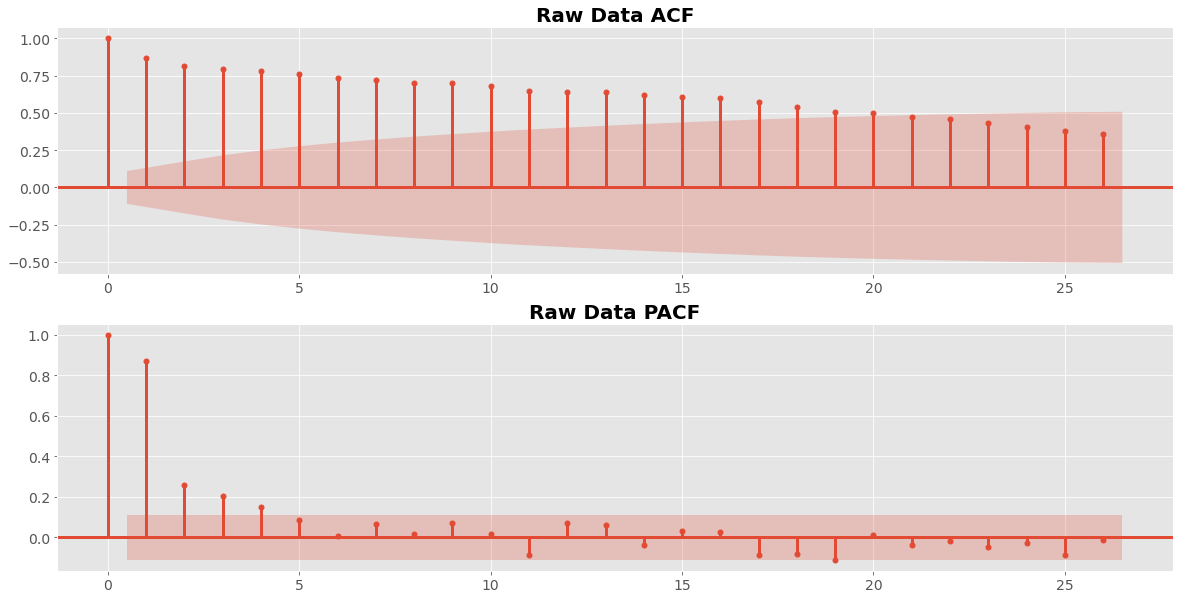

In [24]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

## LOCF Difference + Window 1

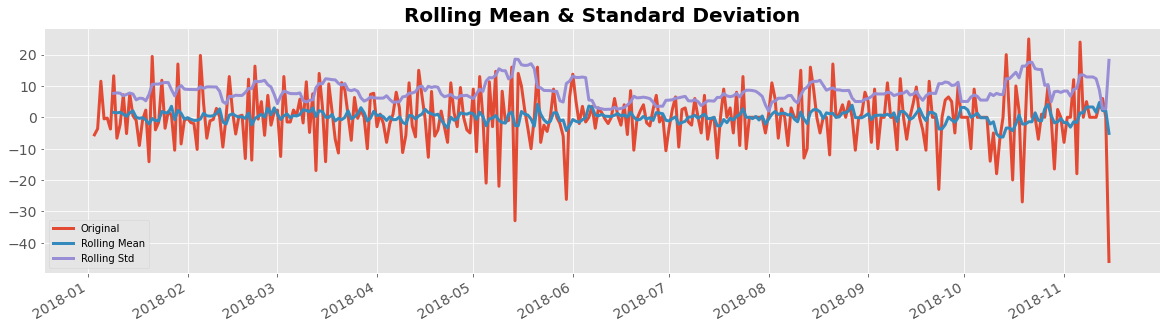

ADF Statistic: -12.47302067209256
p-value: 3.213459931884452e-23
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


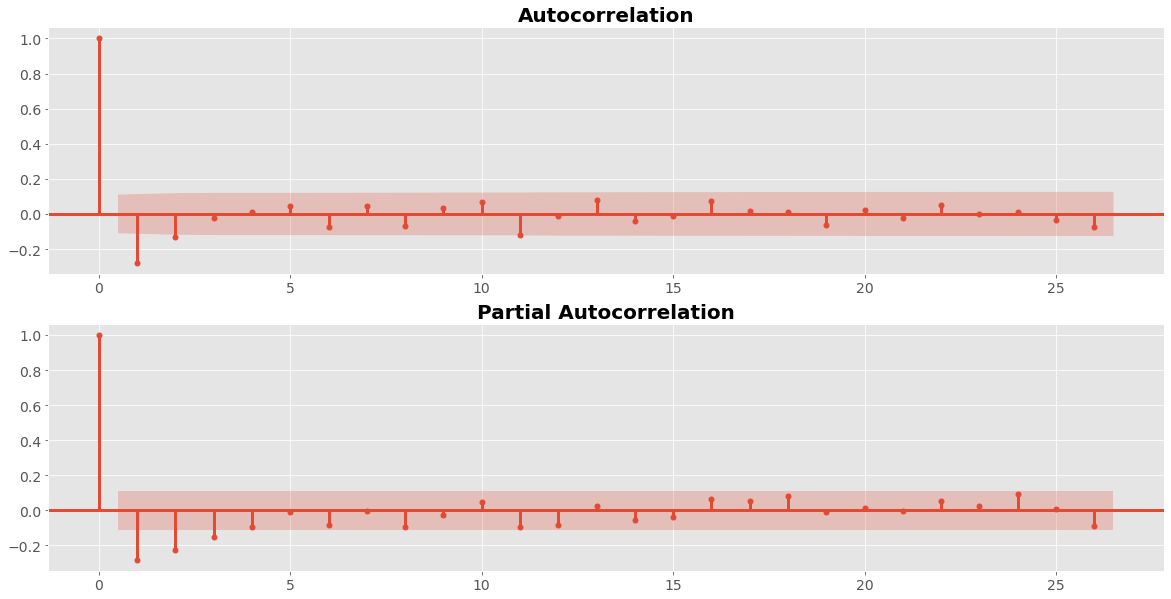

In [25]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

## LOCF Difference + Window 7

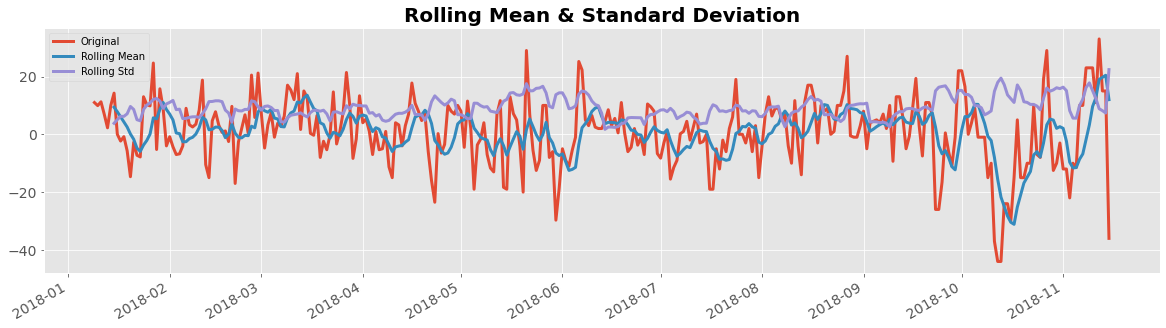

ADF Statistic: -3.169655151564709
p-value: 0.021809730019075612
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


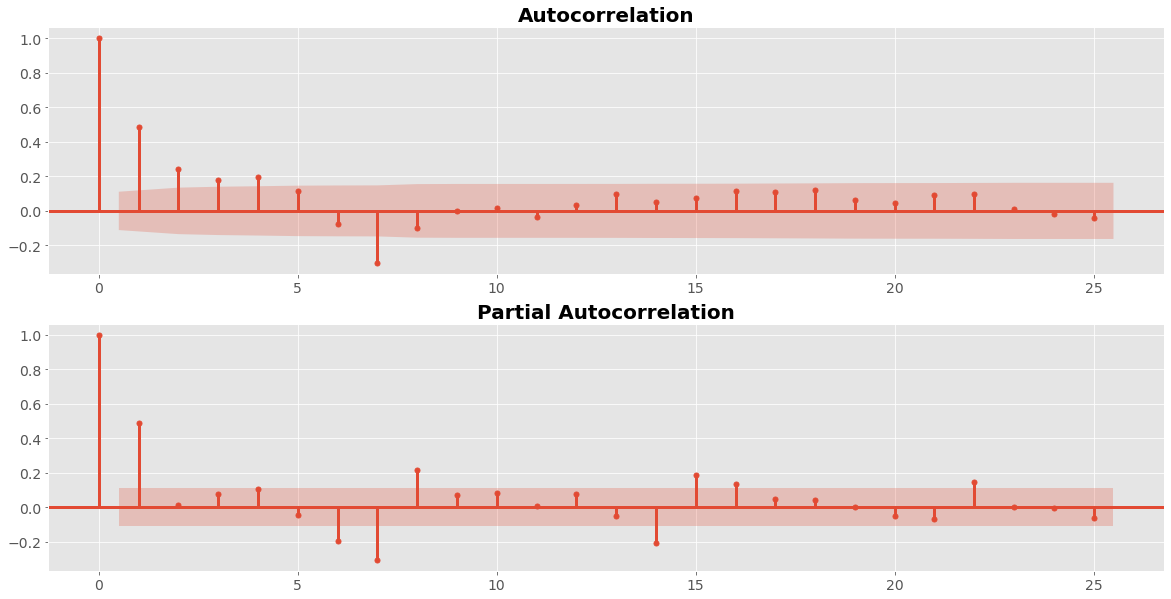

In [26]:
warnings.filterwarnings("ignore")
window = 7
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

As the P-Value of the Augmented Dickey Fuller test is greater than the significant value, we cannot reject the null hypothesis which states that the data is not stationary.

In [26]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = [0, 1, 2]

best_cfg = evaluate_models(train_price, p_values, d_values, q_values, window)

ARIMA (0, 0, 1) MAE = 7.899 RMSE = 10.600 R2 = 0.673
ARIMA (0, 0, 2) MAE = 7.589 RMSE = 10.348 R2 = 0.688
ARIMA (0, 1, 1) MAE = 6.453 RMSE = 10.484 R2 = 0.680
ARIMA (0, 1, 2) MAE = 7.808 RMSE = 10.747 R2 = 0.664
ARIMA (1, 0, 0) MAE = 7.305 RMSE = 10.513 R2 = 0.678
ARIMA (1, 0, 1) MAE = 7.584 RMSE = 10.368 R2 = 0.687
ARIMA (1, 0, 2) MAE = 7.634 RMSE = 10.390 R2 = 0.686
ARIMA (1, 1, 0) MAE = 9.804 RMSE = 13.422 R2 = 0.476
ARIMA (2, 0, 0) MAE = 7.534 RMSE = 10.371 R2 = 0.687
ARIMA (2, 0, 1) MAE = 7.602 RMSE = 10.385 R2 = 0.686
ARIMA (2, 0, 2) MAE = 7.646 RMSE = 10.439 R2 = 0.683
ARIMA (2, 1, 0) MAE = 8.925 RMSE = 12.708 R2 = 0.530
ARIMA (3, 0, 0) MAE = 7.497 RMSE = 10.268 R2 = 0.693
ARIMA (3, 0, 1) MAE = 7.604 RMSE = 10.405 R2 = 0.685
ARIMA (3, 1, 0) MAE = 8.319 RMSE = 11.821 R2 = 0.593

Best ARIMA (0, 1, 1) MAE=6.453 RMSE= 10.484


## Inspect best result

               0
count  79.000000
mean   -0.760458
std    10.522793
min   -46.161887
25%    -2.524455
50%    -0.132249
75%     4.440340
max    24.962078
MAE=6.453 RMSE=10.484 R2=0.680


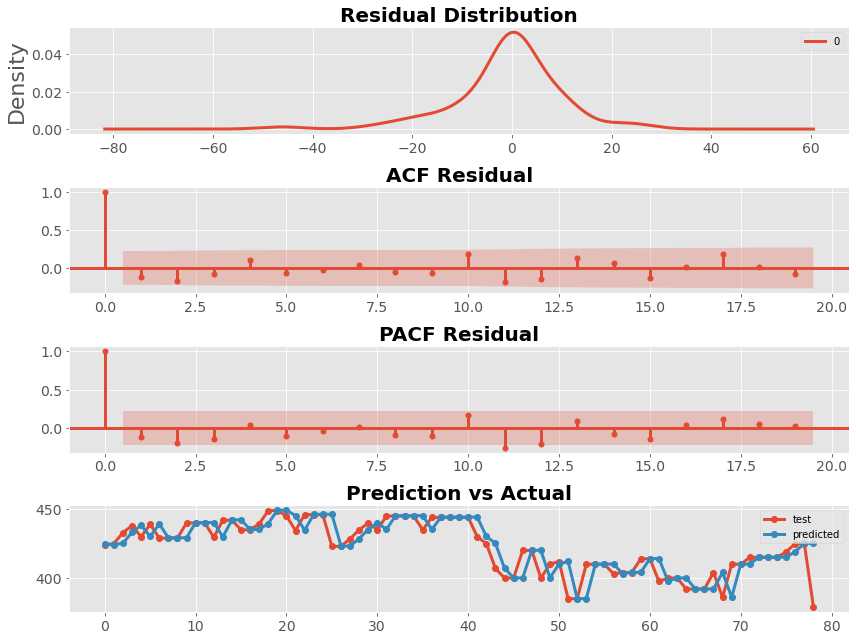

In [28]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Add bias based on residual error

                  0
count  7.900000e+01
mean  -1.439074e-14
std    1.052279e+01
min   -4.540143e+01
25%   -1.763997e+00
50%    6.282091e-01
75%    5.200798e+00
max    2.572254e+01
MAE=6.664 RMSE=10.456 R2=0.682


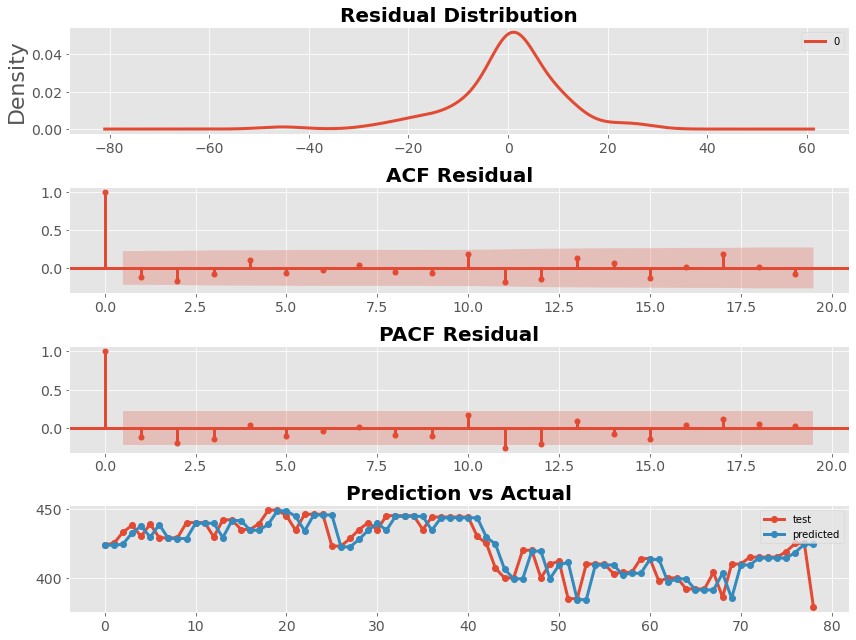

In [26]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg,
                                              window, bias)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Validate Result

In [29]:
bias = 0

### Forecast 1 week

MAE=22.408 RMSE=27.684 R2=-1.858


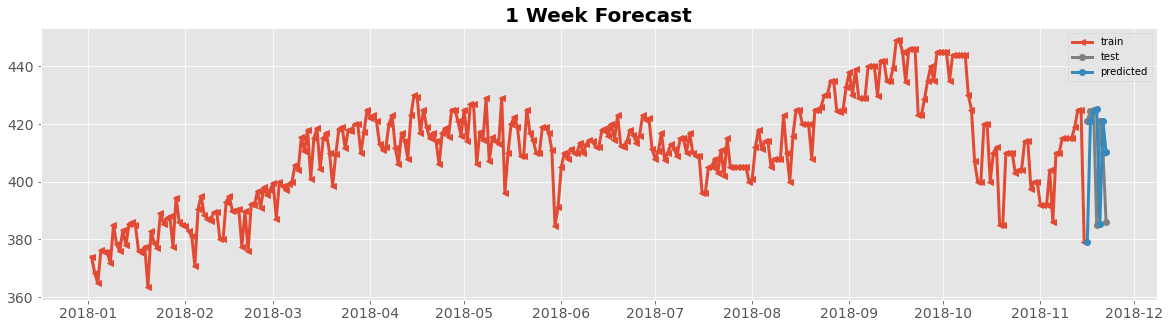

In [30]:
start = test_price.index[0]
end = start + timedelta(days=6)
y1week = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().dropna()

mae, mse, r2, y, ypred = validate_model(y1week, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('1 Week Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y1week.index, y, marker='o', color='gray', label='test')
plt.plot(y1week.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 2 months

MAE=10.855 RMSE=18.978 R2=-0.151


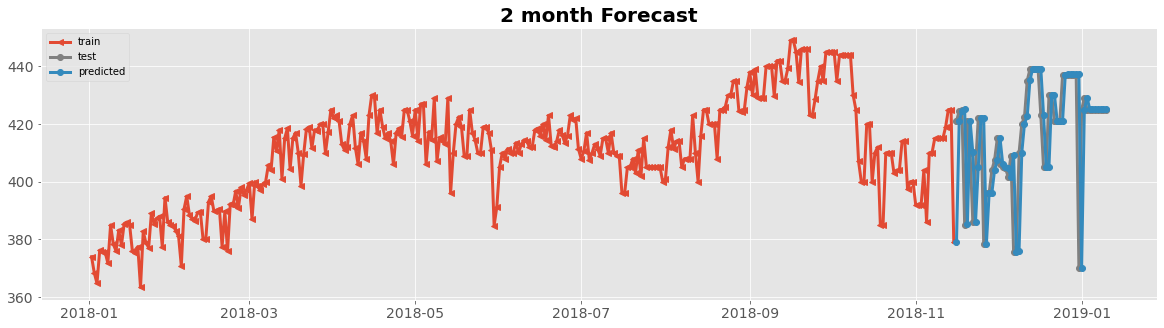

In [31]:
start = test_price.index[0]
end = start + timedelta(days=55)
y2mos = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)

mae, mse, r2, y, ypred = validate_model(y2mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('2 month Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y2mos.index, y, marker='o', color='gray', label='test')
plt.plot(y2mos.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 3 months

MAE=10.064 RMSE=17.239 R2=-0.147


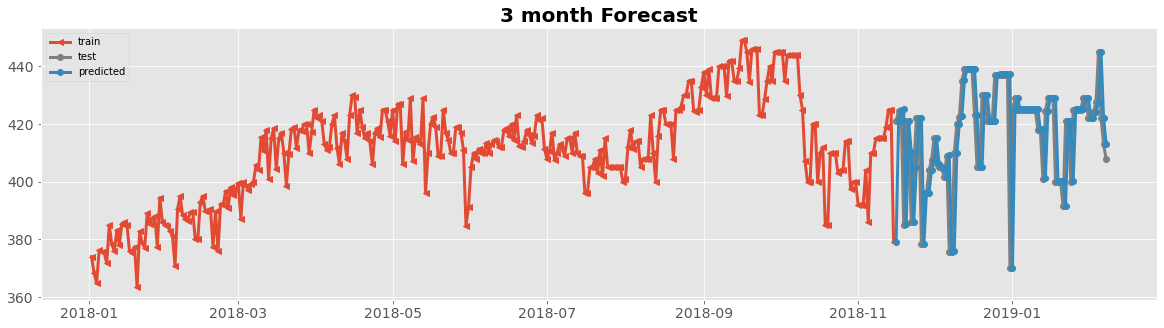

In [32]:
start = test_price.index[0]
end = start + timedelta(days=83)
y3mos = test_price.loc[start:end]

diff = difference(train_price.values.astype('float32'), window)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)

mae, mse, r2, y, ypred = validate_model(y3mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('3 month Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y3mos.index, y, marker='o', color='gray', label='test')
plt.plot(y3mos.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

# Grid Search ARIMA Jordan 1

In [37]:
sale_price = (jordan1_uni_blue_9_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
m1 = sale_price.index >= '2018-06-01'
m2 = sale_price.index <= '2018-10-15'
train_price = sale_price.loc[m1 & m2].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-10-15'].copy()

## Raw Data

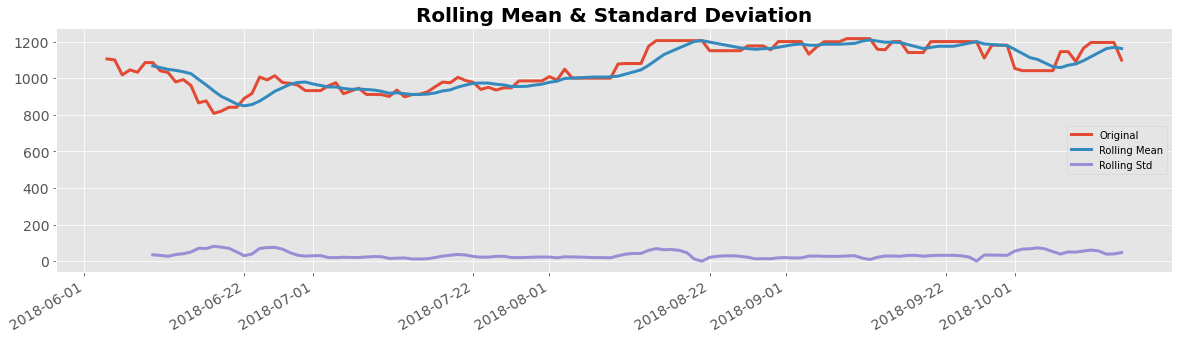

ADF Statistic: -1.8023186474728143
p-value: 0.37931115864251963
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578


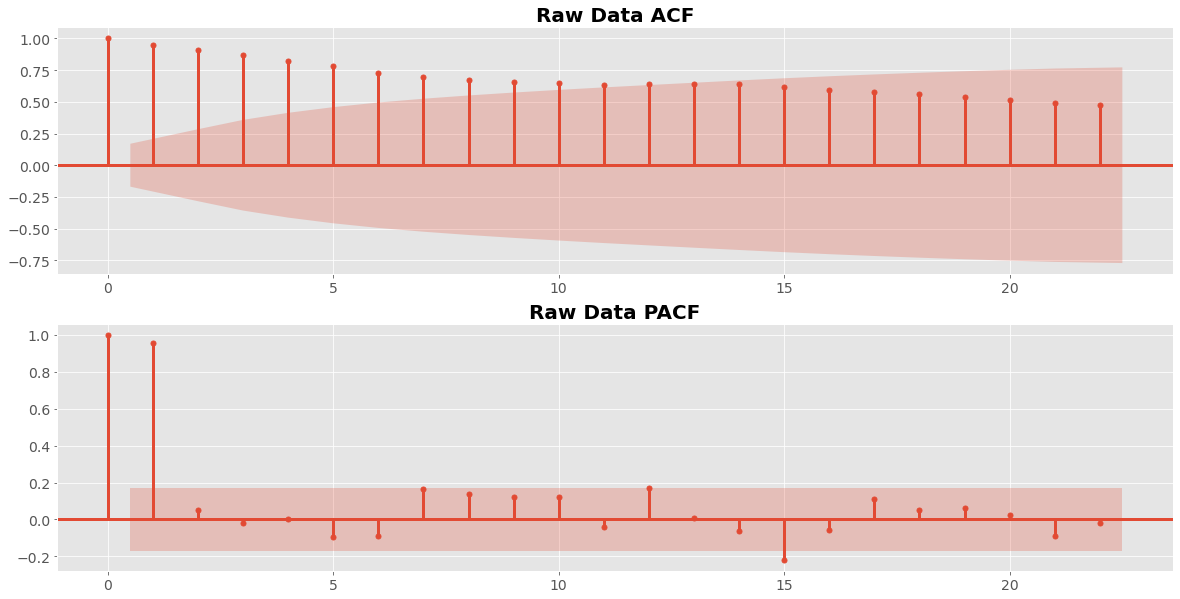

In [38]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

## LOCF Difference + Window 1

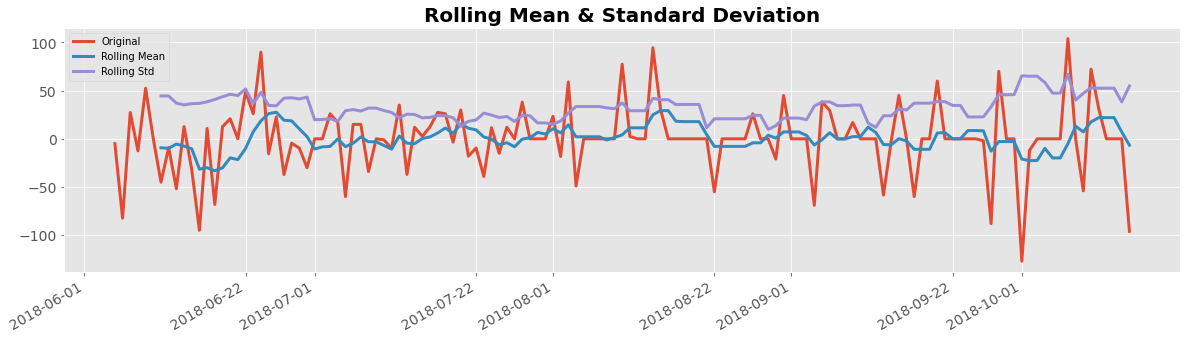

ADF Statistic: -12.136346632492122
p-value: 1.6901011266382825e-22
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


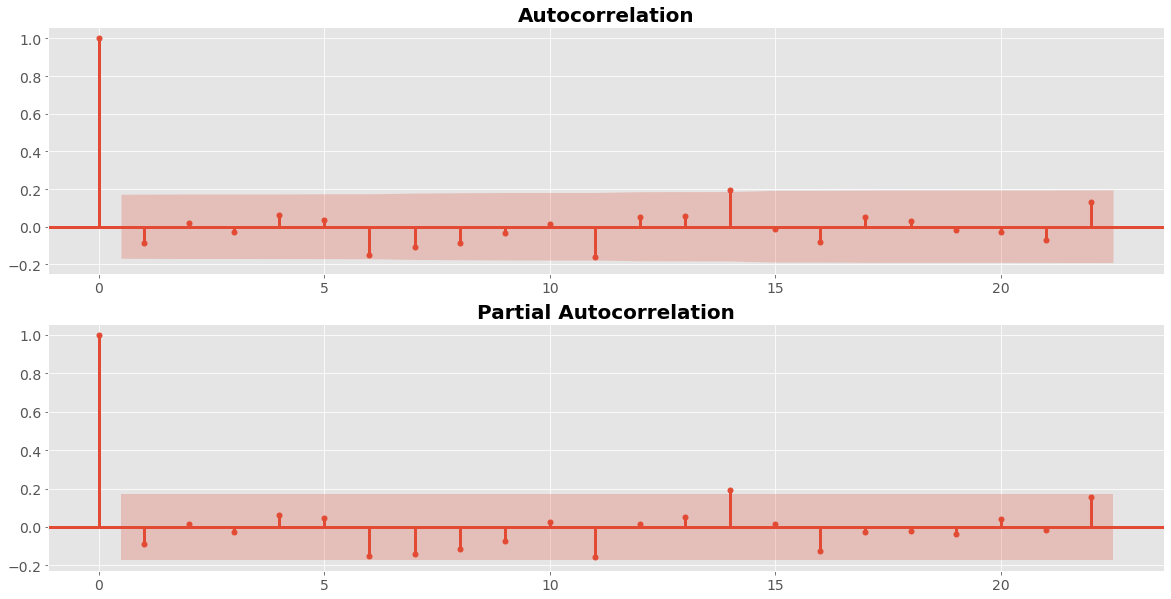

In [43]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

## LOCF Difference + Window 7

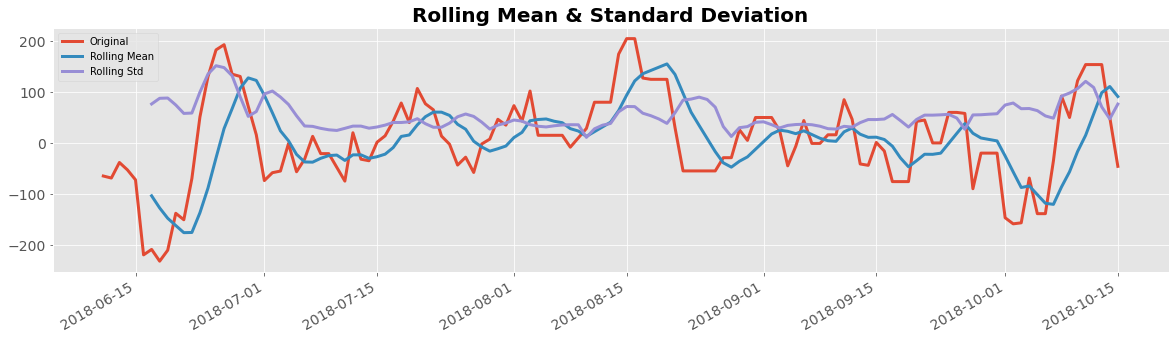

ADF Statistic: -4.106000043312957
p-value: 0.0009466419061043156
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


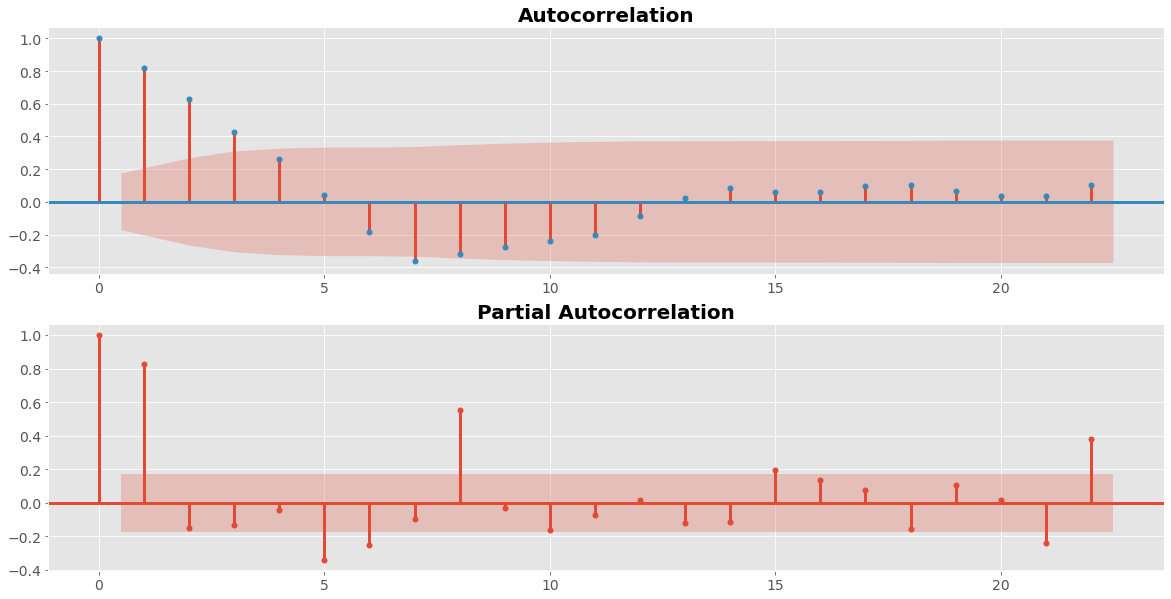

In [40]:
warnings.filterwarnings("ignore")
window = 7
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1, color='#348ABD')
plot_pacf(stationary, ax=ax2)
plt.show()

## Inspect best result

                0
count   33.000000
mean    -4.217443
std     47.142086
min   -127.641007
25%     -3.192911
50%     -0.692276
75%      0.524565
max    104.520299
MAE=27.469 RMSE=46.613 R2=0.348


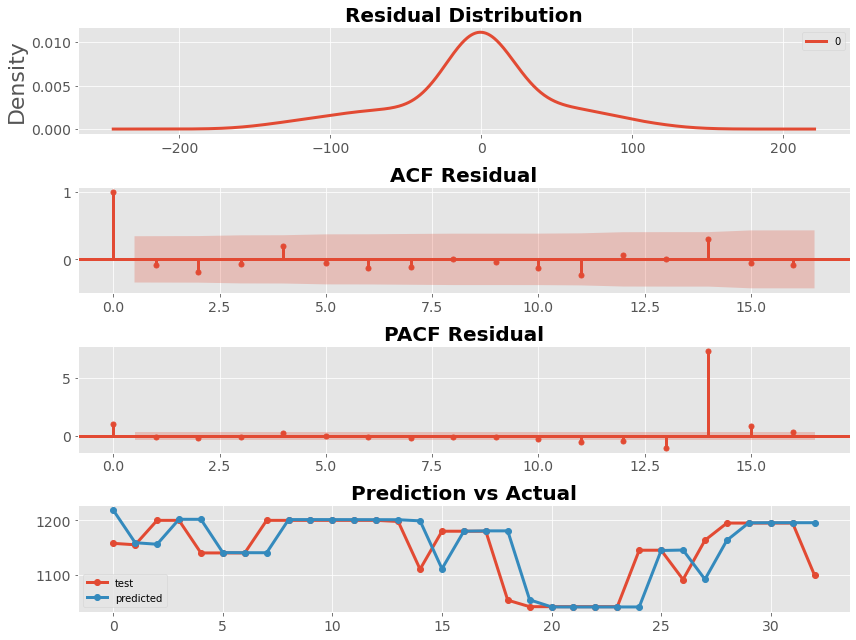

In [44]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

# Grid Search ARIMA Shifted

In [78]:
def is_stationary(timeseries, window=7):
    """Plot timeseries with rolling mean and std, cacl ADF stat"""
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # rolling statistics plot
    plt.figure(figsize=(20, 5))
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


def difference(dataset, interval=1):
    """Creates a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def inverse_difference(history, yhat, interval=1):
    """Inverse Difference of yhat"""
    return yhat + history[-interval]


def evaluate_arima_model(X, arima_order, window, bias=None):
    """Evaluate ARIMA model"""
    X = X.astype('float32')
    test_size = int(len(X) * 0.25)
    train, test = X.iloc[0:-test_size], X.iloc[-test_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(1, len(test)):
        diff = difference(history, window)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat += bias
        predictions.append(yhat)
        history.append(test[i])
    # Calculate out of sample error
    mae = mean_absolute_error(test[:-1], predictions)
    mse = mean_squared_error(test[:-1], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[:-1], predictions)
    return mae, rmse, r2, test[:-1], predictions


def evaluate_models(dataset, p_values, d_values, q_values, window):
    dataset = dataset.astype('float32')
    best_mae, best_rmse, best_cfg = float('inf'), float('inf'), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mae, mse, r2, test, pred = evaluate_arima_model(dataset,
                                                                    order,
                                                                    window)
                    print('ARIMA %s MAE = %.3f RMSE = %.3f R2 = %.3f' %
                          (order, mae, mse, r2))
                    if mae < best_mae:
                        best_mae, best_rmse, best_cfg = mae, mse, order
                except:
                    continue
    print('Best ARIMA %s MAE=%.3f RMSE= %.3f' % (best_cfg,
                                                 best_mae,
                                                 best_rmse))
    return best_cfg


def validate_model(test, train, model_fit, bias, arima_order, window):
    """Validate test using the fitted model of ARIMA"""
    # Make first prediction
    predictions = list()
    history = list(train.values.astype('float32'))
    y = test.values.astype('float32')
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, window)
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecast
    for i in range(2, len(y)):
        # Difference data
        diff = difference(history, window)
        # Predict
        model = ARIMA(diff, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
#         yhat = model_fit.predict(0)[0]
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat = yhat + bias
        predictions.append(yhat)
        # Observation
        history.append(y[i])
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[i]))

    # Report performance
    mse = mean_squared_error(y[:-1], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y[:-1], predictions)
    mae = mean_absolute_error(y[:-1], predictions)
    return mae, rmse, r2, y[:-1], predictions

In [79]:
sale_price = (yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
train_price = sale_price.loc[sale_price.index <= '2018-11-15'].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-11-15'].copy()

## Raw Data

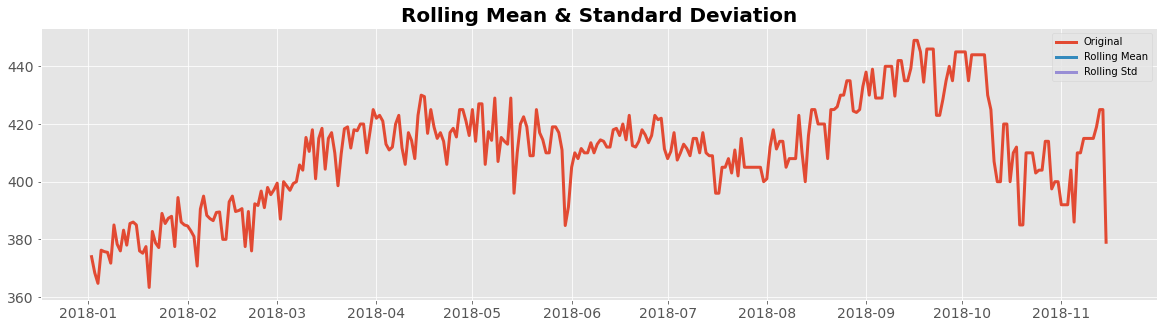

ADF Statistic: -2.6115298788689048
p-value: 0.09063761391742214
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


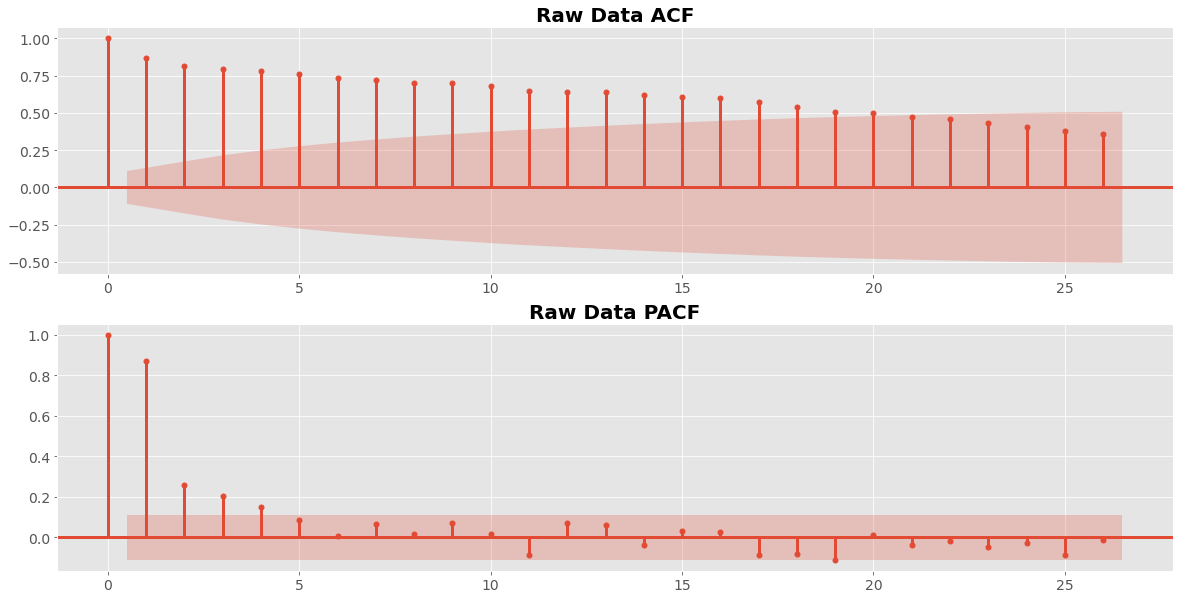

In [80]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

## LOCF Difference + Window 1

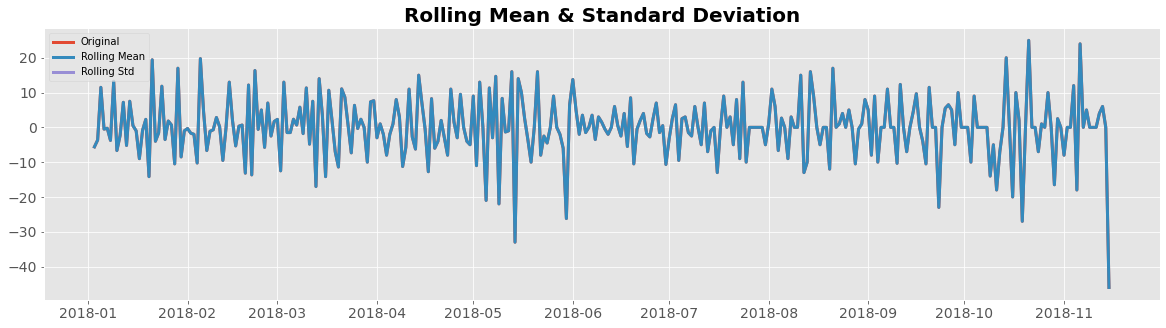

ADF Statistic: -12.47302067209256
p-value: 3.213459931884452e-23
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


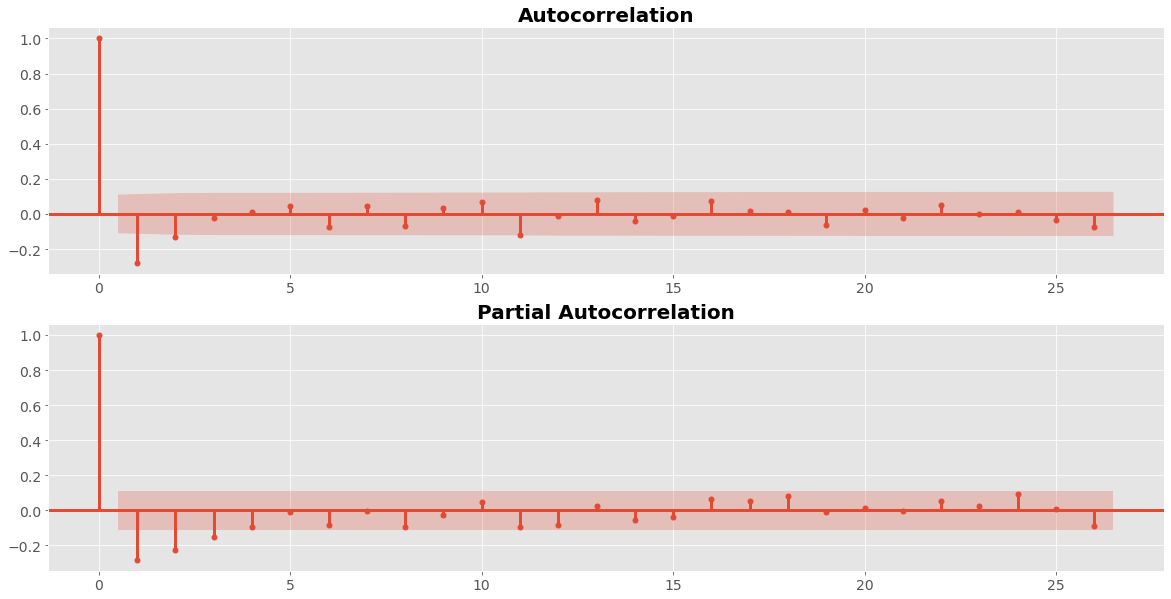

In [81]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

As the P-Value of the Augmented Dickey Fuller test is greater than the significant value, we cannot reject the null hypothesis which states that the data is not stationary.

In [82]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = [0, 1, 2]

best_cfg = evaluate_models(train_price, p_values, d_values, q_values, window)

ARIMA (0, 0, 1) MAE = 4.557 RMSE = 5.692 R2 = 0.900
ARIMA (0, 0, 2) MAE = 4.168 RMSE = 5.243 R2 = 0.915
ARIMA (0, 1, 1) MAE = 0.191 RMSE = 0.215 R2 = 1.000
ARIMA (0, 1, 2) MAE = 4.417 RMSE = 5.764 R2 = 0.897
ARIMA (1, 0, 0) MAE = 2.023 RMSE = 3.079 R2 = 0.971
ARIMA (1, 0, 1) MAE = 4.126 RMSE = 5.223 R2 = 0.916
ARIMA (1, 0, 2) MAE = 4.217 RMSE = 5.306 R2 = 0.913
ARIMA (1, 1, 0) MAE = 4.645 RMSE = 6.109 R2 = 0.884
ARIMA (2, 0, 0) MAE = 3.357 RMSE = 4.257 R2 = 0.944
ARIMA (2, 0, 1) MAE = 4.207 RMSE = 5.300 R2 = 0.913
ARIMA (2, 0, 2) MAE = 4.187 RMSE = 5.304 R2 = 0.913
ARIMA (2, 1, 0) MAE = 3.781 RMSE = 4.849 R2 = 0.927
ARIMA (3, 0, 0) MAE = 3.894 RMSE = 4.807 R2 = 0.928
ARIMA (3, 0, 1) MAE = 4.207 RMSE = 5.316 R2 = 0.912
ARIMA (3, 1, 0) MAE = 3.560 RMSE = 4.458 R2 = 0.938

Best ARIMA (0, 1, 1) MAE=0.191 RMSE= 0.215


## Inspect best result

               0
count  78.000000
mean   -0.191291
std     0.099368
min    -0.757088
25%    -0.255233
50%    -0.209093
75%    -0.122827
max    -0.038044
MAE=0.191 RMSE=0.215 R2=1.000


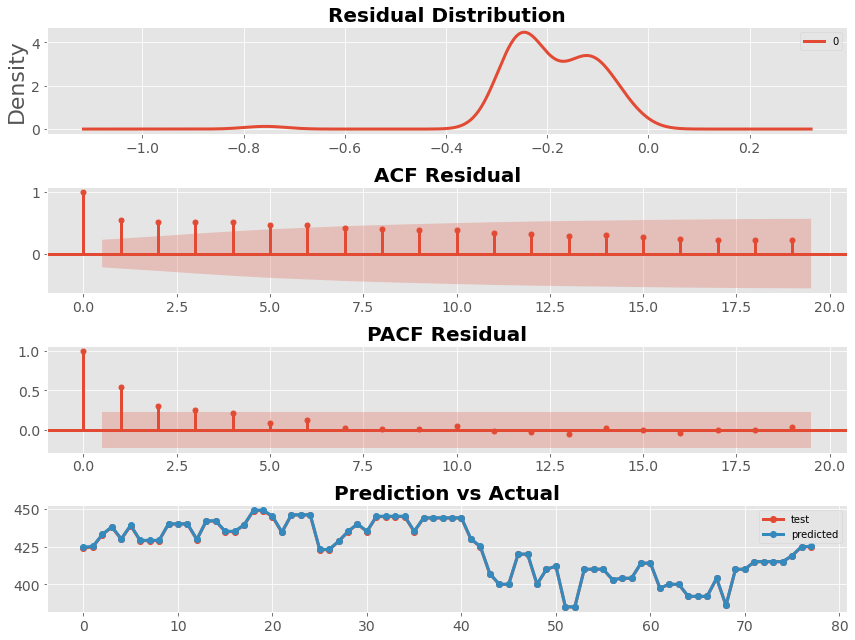

In [83]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Add bias based on residual error

                  0
count  7.800000e+01
mean   8.016380e-15
std    9.936806e-02
min   -5.657967e-01
25%   -6.394201e-02
50%   -1.780181e-02
75%    6.846369e-02
max    1.532475e-01
MAE=0.074 RMSE=0.099 R2=1.000


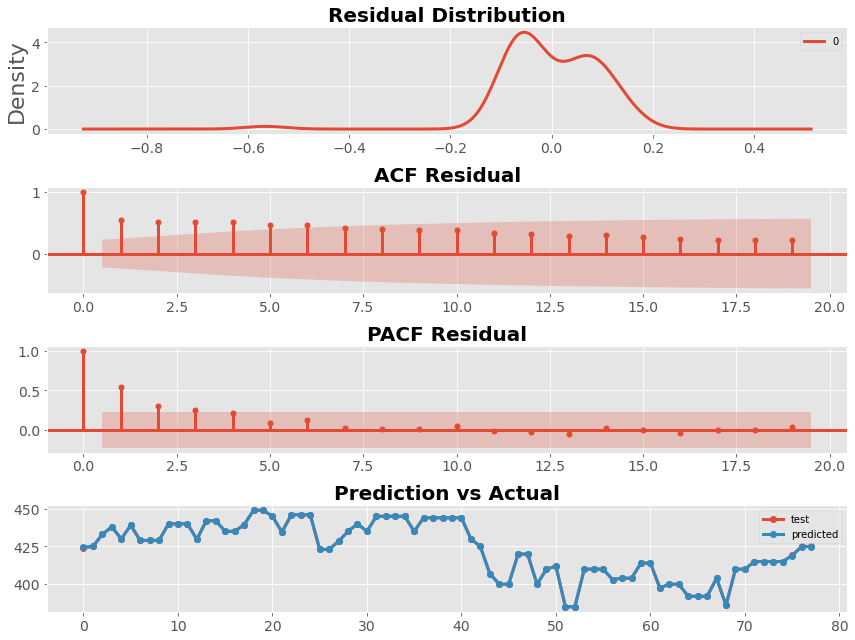

In [84]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg,
                                              window, bias)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Validate Result

### Forecast 1 week

MAE=7.664 RMSE=17.224 R2=-0.502


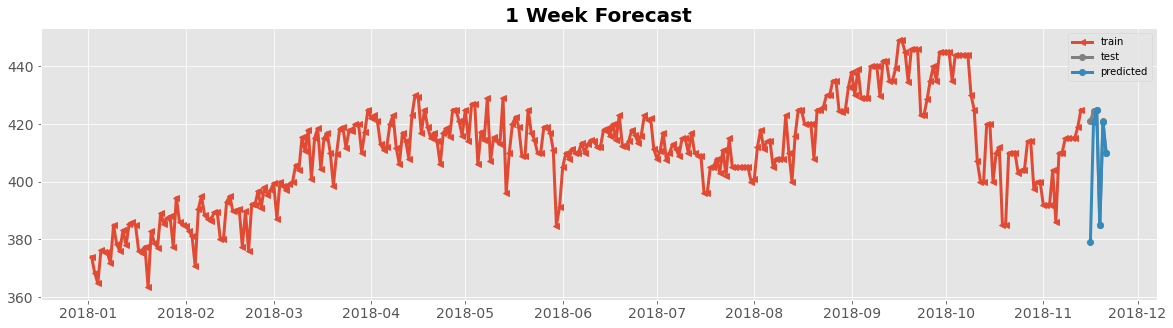

In [85]:
start = test_price.index[0]
end = start + timedelta(days=6)
y1week = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y1week, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('1 Week Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y1week.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y1week.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 2 months

MAE=0.897 RMSE=5.690 R2=0.898


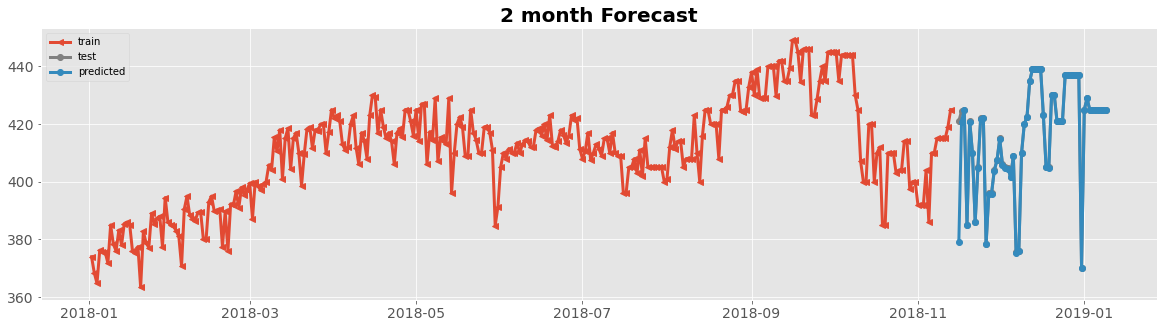

In [86]:
start = test_price.index[0]
end = start + timedelta(days=55)
y2mos = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y2mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('2 month Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y2mos.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y2mos.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 3 months

MAE=0.619 RMSE=4.632 R2=0.918


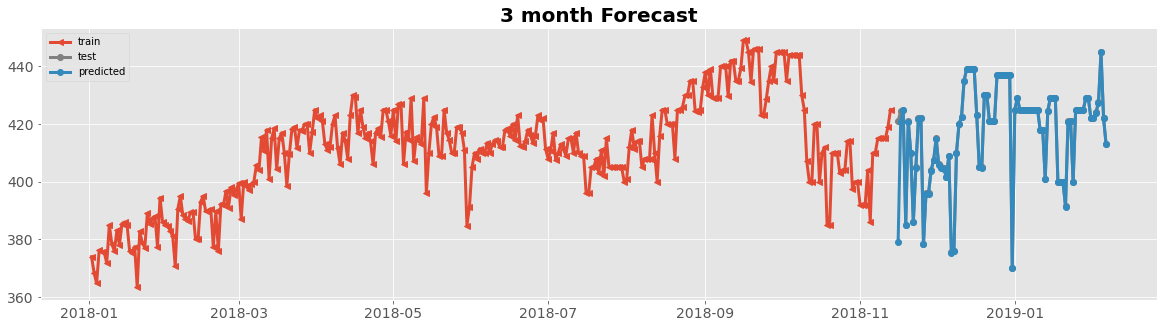

In [87]:
start = test_price.index[0]
end = start + timedelta(days=83)
y3mos = test_price.loc[start:end]

diff = difference(train_price.values.astype('float32'), window)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y3mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('3 month Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y3mos.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y3mos.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()